In [841]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv, GraphConv, TransformerConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn import BatchNorm, LayerNorm
import math
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer

In [842]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)
province_order = adj.columns.tolist()
for i, province in enumerate(province_order):
    province_order[i] = province.upper()

print(province_order)

['SULAWESI TENGAH', 'SULAWESI BARAT', 'SULAWESI SELATAN', 'PAPUA BARAT', 'GORONTALO', 'RIAU', 'DAERAH ISTIMEWA YOGYAKARTA', 'SUMATERA BARAT', 'DKI JAKARTA', 'MALUKU', 'BENGKULU', 'LAMPUNG', 'PAPUA', 'KEPULAUAN RIAU', 'NUSA TENGGARA BARAT', 'JAMBI', 'BALI', 'JAWA TIMUR', 'SUMATERA UTARA', 'SULAWESI TENGGARA', 'NUSA TENGGARA TIMUR', 'KALIMANTAN SELATAN', 'ACEH', 'KALIMANTAN TENGAH', 'KEPULAUAN BANGKA BELITUNG', 'SUMATERA SELATAN', 'BANTEN', 'SULAWESI UTARA', 'KALIMANTAN UTARA', 'KALIMANTAN TIMUR', 'JAWA TENGAH', 'MALUKU UTARA', 'KALIMANTAN BARAT', 'JAWA BARAT']


In [843]:
df = pd.read_excel('Sorted.xlsx')

years = df['Tahun'].unique()

similarity_matrices = {}

for year in years:
    df_year = df[df['Tahun'] == year].copy()

    df_year.set_index('Provinsi', inplace=True)

    input_feature = df_year.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Tahun', 'Stunting'])

    scaler = MinMaxScaler()

    feature_scaled = scaler.fit_transform(input_feature)

    similarity_matrix = cosine_similarity(feature_scaled)

    similarity_df = pd.DataFrame(similarity_matrix,
                                 index=input_feature.index,
                                 columns=input_feature.index)
    
    similarity_matrices[year] = similarity_df

    similarity_df.to_excel(f"Graf 2018-2023/Similarity_Matrix_for_{year}.xlsx")

In [844]:


def get_edge_index_from_similarity(sim_matrix, threshold=0.85):
    edges = []
    n = sim_matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and sim_matrix[i, j] >= threshold:
                edges.append([i, j])
    return torch.tensor(edges).t().contiguous()  # shape [2, num_edges]


In [845]:
adj = pd.read_excel('adjacency_geografi.xlsx', index_col=0)

# Buat mapping provinsi
province_list = adj.columns.tolist()
province_to_idx = {prov.upper(): idx for idx, prov in enumerate(province_list)}

# Buat edge_index
edge_index = []

for i, source in enumerate(province_list):
    for j, target in enumerate(province_list):
        if adj.iloc[i, j] == 1:
            edge_index.append([i, j])  # <--- harus pakai i, j dari enumerate (bukan nilai dari file langsung)

edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, num_edges]

In [846]:
graphs_spatial = []
graphs_similarity = []

for tahun in years:
    # ambil fitur dan target provinsi di tahun ini
    fitur_tahun = df[df['Tahun'] == tahun].drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'Tahun', 'Stunting'])
    target_tahun = df[df['Tahun'] == tahun]['Stunting']
    sim_matrix = similarity_matrices[tahun].values # N x N matrix
    
    x = torch.tensor(fitur_tahun.values, dtype=torch.float)
    y = torch.tensor(target_tahun.values, dtype=torch.float)
    
    # adjacency edge index (tetap)
    edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
    
    # similarity edge index (dinamis)
    edge_index_sim = get_edge_index_from_similarity(sim_matrix, threshold=0.85)

    # buat 2 graph data terpisah
    data_spatial = Data(x=x, edge_index=edge_index_spatial)
    data_similarity = Data(x=x, edge_index=edge_index_sim)

    # simpan
    graphs_spatial.append(data_spatial)
    graphs_similarity.append(data_similarity)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch.tensor(edge_index, dtype=torch.long)  # shape [2, num_edges]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21664\538702535.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index_spatial = torch

In [847]:
print(f'Graph Spacial: {graphs_spatial}')

print(f'Graph Similarity: {graphs_similarity}')

Graph Spacial: [Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62]), Data(x=[34, 8], edge_index=[2, 62])]
Graph Similarity: [Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 906]), Data(x=[34, 8], edge_index=[2, 904]), Data(x=[34, 8], edge_index=[2, 968]), Data(x=[34, 8], edge_index=[2, 938]), Data(x=[34, 8], edge_index=[2, 958])]


In [848]:
for year, (g1, g2) in enumerate(zip(graphs_spatial, graphs_similarity)):
    print(f"Tahun {year + 2018}")
    print("Spatial edge max:", g1.edge_index.max().item())
    print("Similarity edge max:", g2.edge_index.max().item())

Tahun 2018
Spatial edge max: 33
Similarity edge max: 33
Tahun 2019
Spatial edge max: 33
Similarity edge max: 33
Tahun 2020
Spatial edge max: 33
Similarity edge max: 33
Tahun 2021
Spatial edge max: 33
Similarity edge max: 33
Tahun 2022
Spatial edge max: 33
Similarity edge max: 33
Tahun 2023
Spatial edge max: 33
Similarity edge max: 33


In [849]:
# class DualBranchGNN(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()
        
#         # Branch 1: Spatial Graph
#         self.conv_spatial_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_spatial_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_spatial_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_spatial_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Branch 2: Similarity Graph
#         self.conv_sim_1 = SAGEConv(in_channels, hidden_channels)
#         self.norm_sim_1 = torch.nn.LayerNorm(hidden_channels)
        
#         self.conv_sim_2 = SAGEConv(hidden_channels, hidden_channels)
#         self.norm_sim_2 = torch.nn.LayerNorm(hidden_channels)
        
#         # Output layer
#         self.out_layer = torch.nn.Linear(hidden_channels * 2, out_channels)

#     def forward(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate
#         x = torch.cat([x1, x2], dim=1)
#         out = self.out_layer(x)
#         return out

#     def get_embedding(self, data_spatial, data_sim):
#         # Spatial branch
#         x1 = self.conv_spatial_1(data_spatial.x, data_spatial.edge_index)
#         x1 = self.norm_spatial_1(x1)
#         x1 = F.relu(x1)
        
#         x1 = self.conv_spatial_2(x1, data_spatial.edge_index)
#         x1 = self.norm_spatial_2(x1)
#         x1 = F.relu(x1)
        
#         # Similarity branch
#         x2 = self.conv_sim_1(data_sim.x, data_sim.edge_index)
#         x2 = self.norm_sim_1(x2)
#         x2 = F.relu(x2)
        
#         x2 = self.conv_sim_2(x2, data_sim.edge_index)
#         x2 = self.norm_sim_2(x2)
#         x2 = F.relu(x2)
        
#         # Concatenate tanpa output layer
#         x = torch.cat([x1, x2], dim=1)  # Ini hasil embedding gabungan
#         return x




In [850]:
# model = DualBranchGNN(in_channels=8, hidden_channels=256, out_channels=1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# loss_fn = torch.nn.MSELoss()

# best_loss = float('inf')
# best_model_state = None

# for epoch in range(1000):
#     model.train()
#     total_loss = 0

#     for year in range(6):  # 6 tahun
#         data_spatial = graphs_spatial[year]
#         data_sim = graphs_similarity[year]
#         y_true = data_spatial.y.view(-1, 1)  # Target
        
#         optimizer.zero_grad()
#         out = model(data_spatial, data_sim)
#         loss = loss_fn(out, y_true)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Simpan model jika loss lebih baik
#     if total_loss < best_loss:
#         best_loss = total_loss
#         best_model_state = model.state_dict()  # Save best weights

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch} - Loss: {total_loss:.4f} {'(BEST)' if total_loss == best_loss else ''}")



In [851]:
# model.load_state_dict(best_model_state)
# model.eval()
# all_preds = []
# all_targets = []
# gnn_embeddings_all = []

# with torch.no_grad():
#     for spatial_data, sim_data in zip(graphs_spatial, graphs_similarity):
#         # Kirim kedua data ke model
#         out = model(spatial_data, sim_data)

#         embedding = model.get_embedding(spatial_data, sim_data)
#         gnn_embeddings_all.append(embedding)

#         y_pred = out.squeeze().cpu().numpy()
#         y_true = spatial_data.y.squeeze().cpu().numpy()  # atau sim_data.y, sama saja

#         all_preds.extend(y_pred)
#         all_targets.extend(y_true)


# gnn_embeddings_all = torch.cat(gnn_embeddings_all, dim=0)  # [204, hidden_dim*2]
# print(gnn_embeddings_all.shape)

# for true, pred in zip(all_targets, all_preds):
#     print(f'True Value: {round(float(true), 2)}, Predicted: {round(float(pred), 2)}')

In [852]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x







In [853]:
from torch_geometric.nn.models import DeepGraphInfomax

def corruption(x, edge_index):
    # Shuffle fitur node (negatif sampel)
    return x[torch.randperm(x.size(0))], edge_index

def create_dgi_model(in_channels, hidden_channels):
    encoder = GCNEncoder(in_channels, hidden_channels)
    dgi = DeepGraphInfomax(
        hidden_channels=hidden_channels,
        encoder=encoder,
        summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
        corruption=corruption
    )
    return dgi


In [854]:
def train_dgi(dgi, data, epochs=100, lr=0.001):
    optimizer = torch.optim.AdamW(dgi.parameters(), lr=lr)
    dgi.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        pos_z, neg_z, summary = dgi(data.x, data.edge_index)
        loss = dgi.loss(pos_z, neg_z, summary)
        loss.backward()
        optimizer.step()
    dgi.eval()
    with torch.no_grad():
        z, _, _ = dgi(data.x, data.edge_index)
    return z  # [34, hidden_dim]


In [855]:
all_embeddings = []

for tahun in range(len(graphs_spatial)):
    print(f"Tahun {tahun}")
    
    # Spatial Graph
    dgi_spatial = create_dgi_model(in_channels=8, hidden_channels=64)
    emb_spatial = train_dgi(dgi_spatial, graphs_spatial[tahun])
    
    # Similarity Graph
    dgi_sim = create_dgi_model(in_channels=8, hidden_channels=64)
    emb_sim = train_dgi(dgi_sim, graphs_similarity[tahun])
    
    # Concatenate [34, 32]
    emb_combined = torch.cat([emb_spatial, emb_sim], dim=1)
    
    # Tambahkan ke list
    all_embeddings.append(emb_combined)


Tahun 0
Tahun 1
Tahun 2
Tahun 3
Tahun 4
Tahun 5


In [856]:
nama_fitur = fitur_tahun.columns
print(nama_fitur)

Index(['SD / Sederajat', 'SMP / Sederajat', 'SMA / Sederajat',
       'Prevalensi Ketidakcukupan Konsumsi Pangan (Persen)',
       'Konsumsi Kalori Per Hari Per Kapita',
       'Konsumsi Protein Per Hari Per Kapita', 'Kemisikinan Maret',
       'Akses Sanitasi Bersih'],
      dtype='object')


# Using GNN Embedding

In [857]:
from tabpfn import TabPFNRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA

# Load dan preprocessing
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']


print(np.array(all_embeddings).shape)
x_gnn = np.array(all_embeddings).reshape(-1, 128)
print(np.array(x_gnn).shape)


scaler = MinMaxScaler()

X_combined = np.concatenate([x_gnn, X], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(6, 34, 128)
(204, 128)


In [858]:
from pytorch_tabnet.tab_model import TabNetRegressor
reg = TabNetRegressor(
    n_d=24,
    n_a=24,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    momentum=0.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01, weight_decay=1e-5),
    mask_type='entmax',        # 'sparsemax' or 'entmax'
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="min", patience=10, factor=0.7),
    seed=42,
    verbose=1
)

reg.fit(
    X_train, np.array(y_train).reshape(-1, 1),
    max_epochs=200,
    patience=30,               # Early stopping patience
    batch_size=512,
    virtual_batch_size=128,    # For ghost batch normalization
    num_workers=0,
    drop_last=False,
    loss_fn=None               # Uses MSE by default for regression
)


epoch 0  | loss: 552.37885|  0:00:00s
epoch 1  | loss: 525.21655|  0:00:00s


c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 2  | loss: 497.32959|  0:00:00s
epoch 3  | loss: 470.49127|  0:00:00s
epoch 4  | loss: 439.43118|  0:00:00s
epoch 5  | loss: 411.2702|  0:00:00s
epoch 6  | loss: 384.66138|  0:00:00s
epoch 7  | loss: 357.31876|  0:00:00s
epoch 8  | loss: 325.43198|  0:00:00s
epoch 9  | loss: 293.88715|  0:00:00s
epoch 10 | loss: 268.84442|  0:00:00s
epoch 11 | loss: 241.47743|  0:00:00s
epoch 12 | loss: 216.68802|  0:00:00s
epoch 13 | loss: 195.37253|  0:00:00s
epoch 14 | loss: 170.18057|  0:00:00s
epoch 15 | loss: 146.70567|  0:00:00s
epoch 16 | loss: 126.76576|  0:00:00s
epoch 17 | loss: 110.66786|  0:00:00s
epoch 18 | loss: 91.64781|  0:00:00s
epoch 19 | loss: 75.8807 |  0:00:00s
epoch 20 | loss: 63.69575|  0:00:00s
epoch 21 | loss: 54.03188|  0:00:00s
epoch 22 | loss: 48.18882|  0:00:00s
epoch 23 | loss: 35.09963|  0:00:00s
epoch 24 | loss: 28.15937|  0:00:00s
epoch 25 | loss: 31.43242|  0:00:00s
epoch 26 | loss: 22.57433|  0:00:01s
epoch 27 | loss: 29.17679|  0:00:01s
epoch 28 | loss: 27.142

In [859]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    iterations=865,
    depth=8,
    learning_rate=0.06776272583857657,
    l2_leaf_reg=2.957811554875259,
    random_strength=1.006841070057302,
    bagging_temperature=0.2530268852604008,
    loss_function='RMSE',   # WAJIB karena ini regression
    verbose=1               # biar tidak terlalu banyak output saat training
)

cat.fit(X_train, y_train)

0:	learn: 6.6616100	total: 5.69ms	remaining: 4.92s
1:	learn: 6.4923948	total: 14.1ms	remaining: 6.07s
2:	learn: 6.3290271	total: 46.7ms	remaining: 13.4s
3:	learn: 6.1926686	total: 63.5ms	remaining: 13.7s
4:	learn: 6.0331027	total: 72.3ms	remaining: 12.4s
5:	learn: 5.8899212	total: 89.8ms	remaining: 12.9s
6:	learn: 5.7702457	total: 107ms	remaining: 13.1s
7:	learn: 5.6570717	total: 125ms	remaining: 13.3s
8:	learn: 5.5566651	total: 142ms	remaining: 13.5s
9:	learn: 5.4721539	total: 157ms	remaining: 13.4s
10:	learn: 5.3781159	total: 171ms	remaining: 13.3s
11:	learn: 5.3026523	total: 190ms	remaining: 13.5s
12:	learn: 5.2116398	total: 206ms	remaining: 13.5s
13:	learn: 5.1328077	total: 210ms	remaining: 12.7s
14:	learn: 5.0401168	total: 224ms	remaining: 12.7s
15:	learn: 4.9925455	total: 228ms	remaining: 12.1s
16:	learn: 4.9170926	total: 246ms	remaining: 12.3s
17:	learn: 4.8349068	total: 261ms	remaining: 12.3s
18:	learn: 4.7862893	total: 274ms	remaining: 12.2s
19:	learn: 4.7065586	total: 289ms	r

In [860]:
tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)
tabfpn.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [861]:
y_pred = cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 18.283061600456257
MAE: 3.2824622722897008
R2 Score: 0.5840548910978132


In [862]:
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 29.100854091683768
MAE: 4.335799743838426
R2 Score: 0.3379468828125598


In [863]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 7.318476485820848
MAE: 2.0391778089942
R2 Score: 0.8335024753831776


In [864]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 19.906893910024593
MAE: 3.5680000000000134
R2 Score: 0.5471122213413739


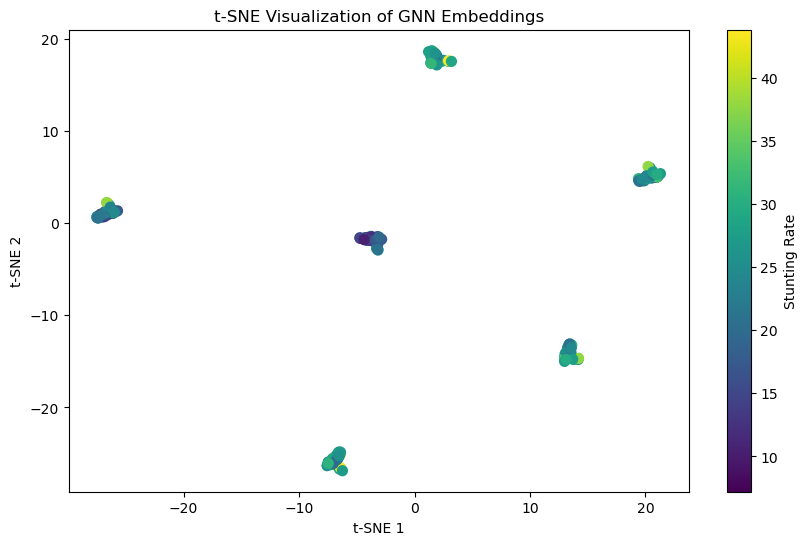

In [865]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Misal X adalah embedding dari GNN (204, 512)
X = x_gnn

# Jalankan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=50)
plt.title("t-SNE Visualization of GNN Embeddings")
plt.colorbar(label='Stunting Rate')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# Without GNN Embedding

In [873]:
df = pd.read_excel('Sorted.xlsx')
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Provinsi', 'SMP / Sederajat', 'SMA / Sederajat'])

X = df.drop(columns='Stunting')
y = df['Stunting']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [874]:
reg = TabNetRegressor(
    n_d=24,
    n_a=24,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    momentum=0.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01, weight_decay=1e-5),
    mask_type='entmax',        # 'sparsemax' or 'entmax'
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params=dict(mode="min", patience=10, factor=0.7),
    seed=42,
    verbose=1
)

cat = CatBoostRegressor(
    iterations=865,
    depth=8,
    learning_rate=0.06776272583857657,
    l2_leaf_reg=2.957811554875259,
    random_strength=1.006841070057302,
    bagging_temperature=0.2530268852604008,
    loss_function='RMSE',   # WAJIB karena ini regression
    verbose=1               # biar tidak terlalu banyak output saat training
)

tabfpn = TabPFNRegressor(device='cuda' if torch.cuda.is_available() else 'cpu', ignore_pretraining_limits=True)

rf = RandomForestRegressor(n_estimators=1000)

c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [875]:
cat.fit(X_train, y_train)
reg.fit(
    X_train, np.array(y_train).reshape(-1, 1),
    max_epochs=200,
    patience=30,               # Early stopping patience
    batch_size=512,
    virtual_batch_size=128,    # For ghost batch normalization
    num_workers=0,
    drop_last=False,
    loss_fn=None               # Uses MSE by default for regression
)
tabfpn.fit(X_train, y_train)
rf.fit(X_train, y_train)

0:	learn: 6.6400236	total: 2.58ms	remaining: 2.23s
1:	learn: 6.4676273	total: 3.87ms	remaining: 1.67s
2:	learn: 6.3064036	total: 6.63ms	remaining: 1.91s
3:	learn: 6.1588475	total: 8.77ms	remaining: 1.89s
4:	learn: 6.0075861	total: 10.1ms	remaining: 1.74s
5:	learn: 5.8560959	total: 12.3ms	remaining: 1.77s
6:	learn: 5.7268235	total: 14.3ms	remaining: 1.75s
7:	learn: 5.6038063	total: 16.2ms	remaining: 1.73s
8:	learn: 5.4913719	total: 16.8ms	remaining: 1.6s
9:	learn: 5.3861156	total: 18.6ms	remaining: 1.59s
10:	learn: 5.2704660	total: 20.7ms	remaining: 1.61s
11:	learn: 5.1798125	total: 22.4ms	remaining: 1.59s
12:	learn: 5.0956961	total: 24.5ms	remaining: 1.6s
13:	learn: 4.9959077	total: 26.2ms	remaining: 1.59s
14:	learn: 4.8856440	total: 28.1ms	remaining: 1.59s
15:	learn: 4.7898461	total: 29.9ms	remaining: 1.59s
16:	learn: 4.6986186	total: 32.2ms	remaining: 1.61s
17:	learn: 4.6141082	total: 34.1ms	remaining: 1.6s
18:	learn: 4.5393999	total: 36ms	remaining: 1.6s
19:	learn: 4.4474961	total: 

c:\Users\LENOVO\miniconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 563.63617|  0:00:00s
epoch 1  | loss: 520.44629|  0:00:00s
epoch 2  | loss: 504.84341|  0:00:00s
epoch 3  | loss: 467.89856|  0:00:00s
epoch 4  | loss: 438.89706|  0:00:00s
epoch 5  | loss: 415.41199|  0:00:00s
epoch 6  | loss: 375.07974|  0:00:00s
epoch 7  | loss: 351.75064|  0:00:00s
epoch 8  | loss: 321.42645|  0:00:00s
epoch 9  | loss: 296.42719|  0:00:00s
epoch 10 | loss: 269.81573|  0:00:00s
epoch 11 | loss: 249.5107|  0:00:00s
epoch 12 | loss: 227.55011|  0:00:00s
epoch 13 | loss: 208.40321|  0:00:00s
epoch 14 | loss: 186.86494|  0:00:00s
epoch 15 | loss: 162.7077|  0:00:00s
epoch 16 | loss: 144.05386|  0:00:00s
epoch 17 | loss: 132.41489|  0:00:00s
epoch 18 | loss: 108.33552|  0:00:00s
epoch 19 | loss: 96.7469 |  0:00:00s
epoch 20 | loss: 85.95209|  0:00:00s
epoch 21 | loss: 73.56398|  0:00:00s
epoch 22 | loss: 62.52303|  0:00:00s
epoch 23 | loss: 54.23654|  0:00:00s
epoch 24 | loss: 43.13838|  0:00:00s
epoch 25 | loss: 36.96067|  0:00:00s
epoch 26 | loss: 34.0

RandomForestRegressor(n_estimators=1000)

In [876]:
y_pred = cat.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 13.061392758323251
MAE: 2.7433729494779855
R2 Score: 0.7028494159238943


In [877]:
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 54.64850419803657
MAE: 5.622384745900224
R2 Score: -0.2432697830776156


In [878]:
y_pred = tabfpn.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 11.088701653636994
MAE: 2.5889280700683592
R2 Score: 0.7477287274035768


In [879]:
y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 12.876563144280409
MAE: 2.665151463414638
R2 Score: 0.7070543448149875
